# Model Fitting

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

# ==== path ====
CUB_ROOT = '/content/drive/My Drive/Colab Notebooks/DATA425A2/data/CUB_200_2011'
IMG_ROOT = os.path.join(CUB_ROOT, 'images')
CLASSES_TXT = os.path.join(CUB_ROOT, 'classes.txt')
SPLIT_TXT = os.path.join(CUB_ROOT, 'train_test_split.txt')
IMGLIST_TXT = os.path.join(CUB_ROOT, 'images.txt')

# dir settings
DRIVE_EXP_DIR = "/content/drive/My Drive/Colab Notebooks/DATA425A2"
os.makedirs(DRIVE_EXP_DIR, exist_ok=True)
result_path1 = os.path.join(DRIVE_EXP_DIR, "exp1_results.csv")
result_path2 = os.path.join(DRIVE_EXP_DIR, "exp2_results.csv")
models_dir = os.path.join(DRIVE_EXP_DIR, "models")
os.makedirs(models_dir, exist_ok=True)

NUM_CLASSES = 200
BATCH_SIZE = 64
EPOCHS = 30

# ==== load img idx ====
imgid2name = {}
with open(IMGLIST_TXT, "r") as f:
    for line in f:
        idx, relpath = line.strip().split()
        imgid2name[int(idx)] = relpath

# ==== classname to id ====
class_name2id = {}
with open(CLASSES_TXT, "r") as f:
    for line in f:
        idx, name = line.strip().split()
        class_name2id[name] = int(idx) - 1

# ==== split by official split.txt ====
train_imglist, val_imglist = [], []
with open(SPLIT_TXT, "r") as f:
    for line in f:
        idx, is_train = line.strip().split()
        img_relpath = imgid2name[int(idx)]
        class_folder = img_relpath.split('/')[0]
        label = class_name2id[class_folder]
        full_path = os.path.join(IMG_ROOT, img_relpath)
        if int(is_train) == 1:
            train_imglist.append((full_path, label))
        else:
            val_imglist.append((full_path, label))

print(f"Train imgs: {len(train_imglist)}, Val imgs: {len(val_imglist)}")  # 5994, 5794

IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

def preprocess_train(image, label):
    image = tf.image.resize_with_pad(image, 256, 256)
    image = tf.image.random_crop(image, size=(224, 224, 3))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    return image, label

def preprocess_val(image, label):
    image = tf.image.resize_with_pad(image, 256, 256)
    image = tf.image.central_crop(image, central_fraction=0.875)
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    return image, label

def decode_img(filename, label):
    try:
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        return img, label
    except:
        # print(f"Decode failed: {filename}")  # for debug use
        return tf.zeros([256,256,3], dtype=tf.float32), label

def build_dataset(img_label_list, batch_size, is_train=True):
    ds = tf.data.Dataset.from_tensor_slices((
        [p for p, l in img_label_list],
        [l for p, l in img_label_list]
    ))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        ds = ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1000)
    else:
        ds = ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_imglist, batch_size=BATCH_SIZE, is_train=True)
val_ds = build_dataset(val_imglist, batch_size=BATCH_SIZE, is_train=False)

for batch in train_ds.take(1):
    images, labels = batch
    print("Train batch:", images.shape, labels.shape)
for batch in val_ds.take(1):
    images, labels = batch
    print("Val batch:", images.shape, labels.shape)

def run_experiment(momentum=0.9, lr=0.01, wd=0.0001, exp_tag=""):
    # model checkpoint path setting
    model_path = os.path.join(models_dir, f"{exp_tag}.weights.h5")
    base = tf.keras.applications.ResNet101V2(include_top=False, weights="imagenet", input_shape=(224,224,3), pooling="avg")
    base.trainable = True
    model = tf.keras.Sequential([
        base,
        tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    ])
    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            layer.kernel_regularizer = tf.keras.regularizers.l2(wd)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor="val_accuracy", save_best_only=True, save_weights_only=True, verbose=1
    )
    
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[checkpoint]
    )
    val_acc_last = history.history["val_accuracy"][-1]  # report the Top-1 validation error at the end of training
    val_error_last = 1 - val_acc_last

    val_error_best = 1 - max(history.history["val_accuracy"])
    val_acc_best   = max(history.history["val_accuracy"])
    
    result = {
        "exp_tag": exp_tag,
        "momentum": momentum,
        "lr": lr,
        "weight_decay": wd,
        "val_error_best": best_val_error,
        "val_acc_best": best_val_acc,
        "val_error_last": history.history["loss"][-1],
        "val_acc_last": history.history["accuracy"][-1],
        "model_path": model_path
    }
    return result, history

def experiment1():
    lrs = [0.01]
    mms = [0.0, 0.8, 0.9, 0.95, 0.99]
    wds = [0.0, 0.0001]
    results = []
    if os.path.exists(result_path1):
        done_df = pd.read_csv(result_path1)
        done_tags = set(done_df["exp_tag"])
        results.extend(done_df.to_dict("records"))
    else:
        done_tags = set()
    for wd in wds:
        for mm in mms:
            for lr in lrs:
                tag = f"exp1_wd{wd}_m{mm}_lr{lr}"
                if tag in done_tags:
                    print(f"Skip completed：{tag}")
                    continue
                print(f"\n==== Running {tag} ====")
                res, _ = run_experiment(momentum=mm, lr=lr, wd=wd, exp_tag=tag)
                results.append(res)
                pd.DataFrame(results).to_csv(result_path1, index=False)
    return pd.DataFrame(results)

def experiment2():
    mms = [0.0, 0.9]
    lrs = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
    wd = 0.0001
    results = []
    if os.path.exists(result_path2):
        done_df = pd.read_csv(result_path2)
        done_tags = set(done_df["exp_tag"])
        results.extend(done_df.to_dict("records"))
    else:
        done_tags = set()
    for mm in mms:
        for lr in lrs:
            tag = f"exp2_m{mm}_lr{lr}"
            if tag in done_tags:
                print(f"Skip completed：{tag}")
                continue
            print(f"\n==== Running {tag} ====")
            res, _ = run_experiment(momentum=mm, lr=lr, wd=wd, exp_tag=tag)
            results.append(res)
            pd.DataFrame(results).to_csv(result_path2, index=False)
    return pd.DataFrame(results)

if __name__ == "__main__":
    print("Running Experiment 1 ...")
    df1 = experiment1()
    print("Exp1 complete. Results in exp1_results.csv")
    print("Running Experiment 2 ...")
    df2 = experiment2()
    print("Exp2 complete. Results in exp2_results.csv")


# Plot

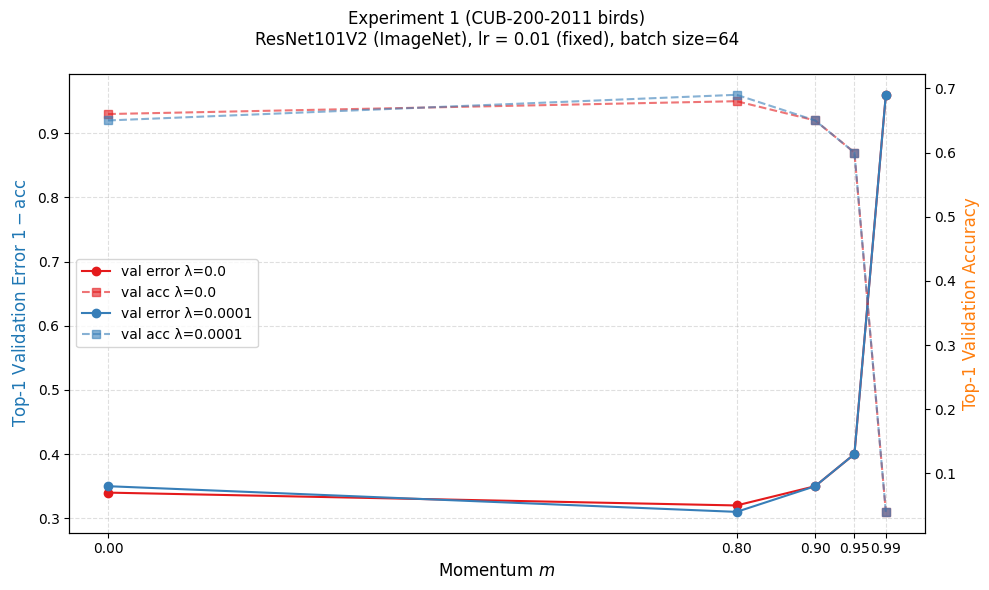

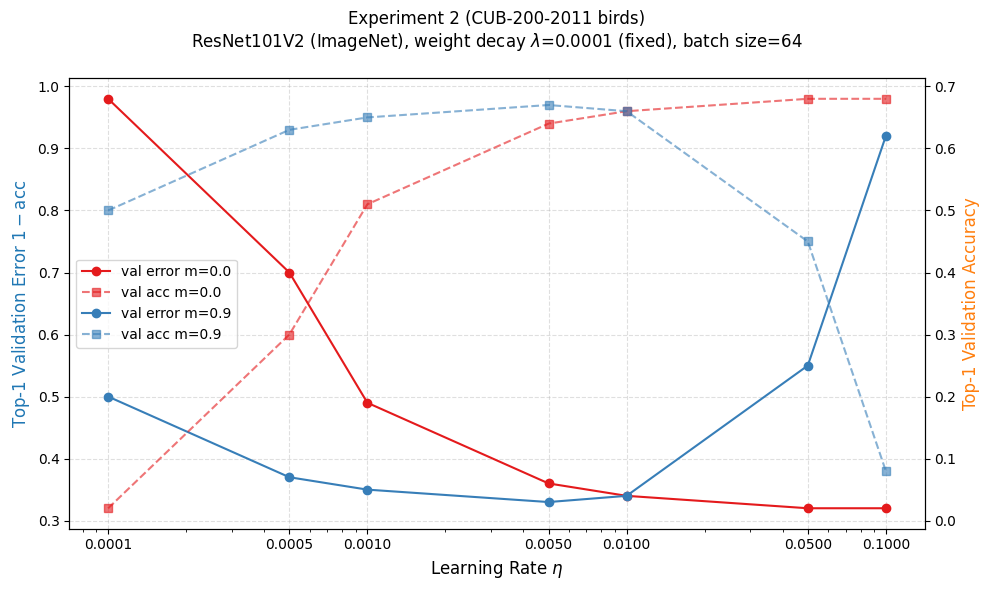

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt

DRIVE_EXP_DIR = "../figures"
result_path1 = os.path.join(DRIVE_EXP_DIR, "exp1_results.csv")
result_path2 = os.path.join(DRIVE_EXP_DIR, "exp2_results.csv")

import matplotlib.pyplot as plt
import numpy as np

def plot_exp1(df, save_path=None):
    x_vals = sorted(df['momentum'].unique())
    color_map = plt.get_cmap('Set1')  # 
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax2 = ax1.twinx()

    lines = []
    labels = []

    for idx, wd in enumerate(sorted(df['weight_decay'].unique())):
        dfg = df[df['weight_decay']==wd].sort_values('momentum')
        color = color_map(idx)
        # principal curve": val_error_last
        line1, = ax1.plot(dfg['momentum'], dfg['val_error_last'], '-o', label=f'λ={wd}', color=color)
        # Subcurve: val_acc_last
        line2, = ax2.plot(dfg['momentum'], dfg['val_acc_last'], '--s', label=f'λ={wd} acc', color=color, alpha=0.6)
        # for xm, yacc in zip(dfg['momentum'], dfg['best_val_acc']):
        #     ax2.annotate(f"{yacc:.2f}", (xm, yacc), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=9, color=color)
        lines.append(line1)
        labels.append(f'val error λ={wd}')
        lines.append(line2)
        labels.append(f'val acc λ={wd}')

    ax1.set_xticks(x_vals)
    ax1.set_xlabel("Momentum $m$", fontsize=12)
    ax1.set_ylabel("Top-1 Validation Error $1-\\mathrm{acc}$", fontsize=12, color='tab:blue')
    ax2.set_ylabel("Top-1 Validation Accuracy", fontsize=12, color='tab:orange')
    ax1.set_title(
        "Experiment 1 (CUB-200-2011 birds)\n"
        "ResNet101V2 (ImageNet), lr = 0.01 (fixed), batch size=64\n"
    )
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.legend(lines, labels, loc='center left', fontsize=10)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()




def plot_exp2(df, save_path=None):
    x_vals = sorted(df['lr'].unique())
    color_map = plt.get_cmap('Set1')
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax2 = ax1.twinx()

    lines = []
    labels = []

    for idx, m in enumerate(sorted(df['momentum'].unique())):
        dfg = df[df['momentum']==m].sort_values('lr')
        color = color_map(idx)
        # principal curve: val_error_last
        line1, = ax1.plot(dfg['lr'], dfg['val_error_last'], '-o', label=f'm={m}', color=color)
        # Subcurve: val_acc_last
        line2, = ax2.plot(dfg['lr'], dfg['val_acc_last'], '--s', label=f'm={m} acc', color=color, alpha=0.6)
        # for xl, yacc in zip(dfg['lr'], dfg['best_val_acc']):
        #     ax2.annotate(f"{yacc:.2f}", (xl, yacc), textcoords="offset points", xytext=(0,-12), ha='center', fontsize=9, color=color)
        lines.append(line1)
        labels.append(f'val error m={m}')
        lines.append(line2)
        labels.append(f'val acc m={m}')

    ax1.set_xscale('log')
    ax1.set_xticks(x_vals)
    ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax1.set_xlabel("Learning Rate $\\eta$", fontsize=12)
    ax1.set_ylabel("Top-1 Validation Error $1-\\mathrm{acc}$", fontsize=12, color='tab:blue')
    ax2.set_ylabel("Top-1 Validation Accuracy", fontsize=12, color='tab:orange')
    ax1.set_title(
        "Experiment 2 (CUB-200-2011 birds)\n"
        "ResNet101V2 (ImageNet), weight decay $\\lambda$=0.0001 (fixed), batch size=64\n"
    )

    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.legend(lines, labels, loc='best', fontsize=10)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


df1 = pd.read_csv(result_path1)
plot_exp1(df1, save_path=os.path.join(DRIVE_EXP_DIR, "exp1_birds_resnet101v2.png"))

df2 = pd.read_csv(result_path2)
plot_exp2(df2, save_path=os.path.join(DRIVE_EXP_DIR, "exp2_birds_resnet101v2.png"))

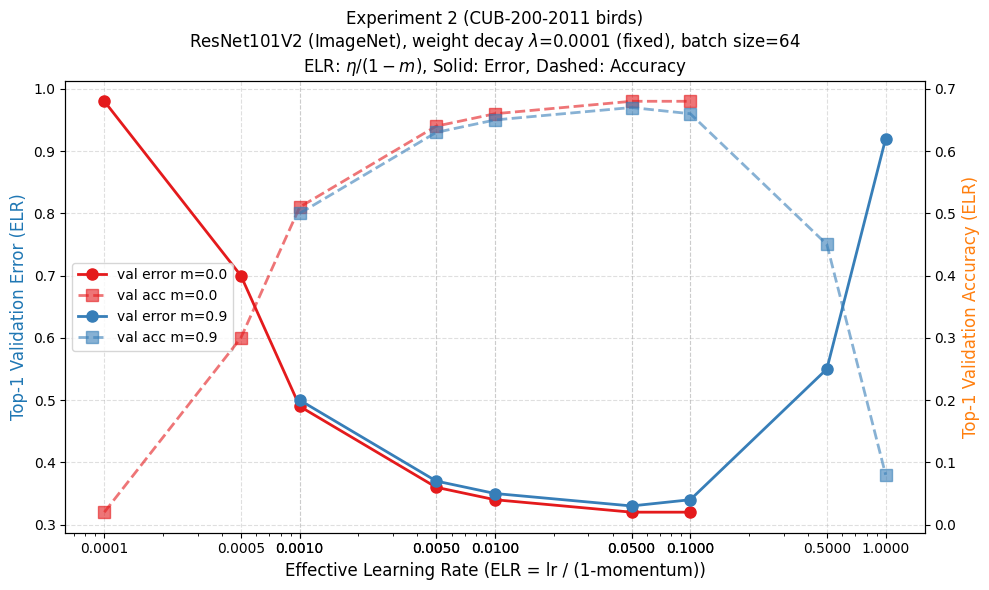

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_exp2_elr(df, save_path=None):
    # add column ELR
    df = df.copy()
    df['ELR'] = df['lr'] / (1 - df['momentum'])
    elr_vals = sorted(df['ELR'].unique())
    color_map = plt.get_cmap('Set1')
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax2 = ax1.twinx()

    lines = []
    labels = []

    for idx, m in enumerate(sorted(df['momentum'].unique())):
        dfg = df[df['momentum']==m].sort_values('ELR')
        color = color_map(idx)
        # ELR principle curve: val_error_last
        line1, = ax1.plot(dfg['ELR'], dfg['val_error_last'], '-o', label=f'm={m}', color=color, linewidth=2, markersize=8)
        # ELR subcurve: val_acc_last
        line2, = ax2.plot(dfg['ELR'], dfg['val_acc_last'], '--s', label=f'm={m} acc', color=color, alpha=0.6, linewidth=2, markersize=8)
        lines.append(line1)
        labels.append(f'val error m={m}')
        lines.append(line2)
        labels.append(f'val acc m={m}')

    ax1.set_xscale('log')
    ax1.set_xticks(elr_vals)
    ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax1.set_xlabel("Effective Learning Rate (ELR = lr / (1-momentum))", fontsize=12)
    ax1.set_ylabel("Top-1 Validation Error (ELR)", fontsize=12, color='tab:blue')
    ax2.set_ylabel("Top-1 Validation Accuracy (ELR)", fontsize=12, color='tab:orange')
    ax1.set_title(
        "Experiment 2 (CUB-200-2011 birds)\n"
        "ResNet101V2 (ImageNet), weight decay $\\lambda$=0.0001 (fixed), batch size=64\n"
        "ELR: $\\eta/(1-m)$"
    )
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.legend(lines, labels, loc='center left', fontsize=10)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# relative csv path
df2 = pd.read_csv("../figures/exp2_results.csv")
plot_exp2_elr(df2, save_path="../figures/exp2_birds_resnet101v2_ELR.png")
